# Project  "Digital library Mybook - Ratings Analysis"

by Glaktionova Natalia

### Парсинг сайта

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from fake_useragent import UserAgent
from selenium.webdriver.chrome.options import Options
import numpy as np
import pandas as pd  
from random import randint
import time  

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
chromedriver = 'C:\\chromedriver.exe'
options = Options()
options.add_argument('headless')  # для открытия headless-браузера
browser = webdriver.Chrome(executable_path=chromedriver, chrome_options=options)

Для начала найдем общее количество страниц

In [4]:
page_link = 'https://mybook.ru/catalog/books/?page=1&t=text'

In [5]:
browser.get(page_link)

In [6]:
page_number_links = browser.find_elements_by_class_name("PageButton__button")
max_page = page_number_links[-1].text

In [7]:
max_page = 101 # Сайт работает некорректно, берем реально доступные страницы

In [8]:
def getPageLinks(page_number):
    """
        Возвращает список ссылок, полученный с текущей страницы
       
    """
    # составляем ссылку на страницу поиска
    page_link = 'https://mybook.ru/catalog/books/?page={}&t=text'.format(page_number)
    
    browser.get(page_link)
    elements = browser.find_elements_by_xpath("//div[@class='ContextBookCardLong__bookTitle']/a")
    
    book_links = []
    for elem in elements:
        book_links.append(elem.get_attribute("href"))
        
    return book_links

Собираем ссылки на все книги

In [9]:
all_book_links = []
for i in range (1, max_page+1):
    all_book_links += getPageLinks(i)

In [10]:
len(all_book_links)

1010

In [11]:
browser.close()
browser.quit()

In [12]:
import socks
import socket
socks.set_default_proxy(socks.SOCKS5, "localhost", 9150)
socket.socket = socks.socksocket

In [13]:
def getData(page):
    """
        Запрашивает данные по книге, возвращает словарь с данными
   
    """
   
    response = requests.get(page, headers={'User-Agent': UserAgent().chrome})
    
    if not response.ok:
        print(response.status_code, page)
        return response.status_code
    
    html = response.content
    soup = BeautifulSoup(html,'html.parser')
    
    # Имя книги
    name = soup.find('h1', attrs = {'class':'BookPageHeaderContent__coverTitle'}).text
    
    # Автор книги
    author = soup.find('a', attrs = {'class':'BookAuthor__authorName'}).text

    # Рейтинг
    try:
        rating = soup.find('span', attrs = {'class':'BookPageHeaderContent__bookRatingCount'}).text
        rating = float(rating.replace(',', '.'))
    except:
        rating = None

    # Количество прочитавших
    try:
        reader_count = soup.find('div', attrs = {'class':'BookPageHeaderContent__bookReaderCount'}).text
        reader_count = [int(i) for i in reader_count.split() if i.isdigit()] 
        reader_count = reader_count[0]
    except:
        reader_count = None

    # Кол-во страниц, год издания, возрастная категория
    stat = []
    stat_clean = []
    try:
        bookStatistic = soup.findAll('div', attrs = {'class':'BookPageHeaderContent__bookStatisticItem'})
        for st in bookStatistic:
            stat.append(st.text)
        for s in stat:
            stat_clean.append([int(i) for i in s.split() if i.isdigit()])
        page_count = stat_clean[0][0]
        year_ed = stat_clean[1][0]
        for_age = stat[2]
    except:
        page_count = None
        year_ed = None
        for_age = None

    # Дата написания
    details=[]
    try:
        bookDetail = soup.findAll('p', attrs = {'class':'BookDetailAnnotation__metaParagraph'})
        for d in bookDetail:
            details.append(d.text)
        details = [s for s in details if "Дата написания" in s]
        details = details[0]
        details = [int(i) for i in details.split() if i.isdigit()]
        year_writing = details[0]
    except:
        year_writing = None

    # Жанры
    try:
        genresThemes = soup.findAll('div', attrs = {'class':'BookGenresThemes__genresThemesSection'})
        genres_list = genresThemes[0].findAll('div', attrs = {'class':'TagLabel__brown'})
        genres = []
        for g in genres_list:
            genres.append(g.text)
    except:
        genres = None

    # Тэги
    try:
        tags_list = genresThemes[1].findAll('div', attrs = {'class':'TagLabel__brown'})
        tags = []
        for t in tags_list:
            tags.append(t.text)
    except:
        tags = None

    # Издатель
    try:
        publisher = soup.find('div', attrs = {'class':'TagLabel__withoutBorder BookRightholder__rightholderName'}).text
    except:
        publisher = None

    # Количество отзывов
    try:
        review_count = soup.find('div', attrs = {'class':'BookDetailReviewList__link link'})
        review_count = review_count.text
        review_count = review_count.split('\xa0')
        review_count = int(review_count[1])
    except:
        review_count = None
      
    # Количество цитат
    try:
        citation_count = soup.find('div', attrs = {'class':'BookDetailCitationList__link link'})
        citation_count = citation_count.text
        citation_count = citation_count.split('\xa0')
        citation_count = int(citation_count[1])
    except:
        citation_count = None
    
    # Описание
    try:
        descrWrapr = soup.find('div', attrs = {'class':'BookDetailAnnotation__descriptionWrapper'})\
                        .findAll('p', attrs={'class': None})
        desription = ''
        for d in descrWrapr:
            desription += d.text
            desription = desription.replace('\xa0',' ')
    except:
        desription = None

    # Комментарии
    try:
        reviewWrapper = soup.find('div', attrs = {'class':'BookDetailReviewList__reviewListWrapper'})               
        reviews = []
        if reviewWrapper:
            reviewWrapper = reviewWrapper.findAll('div', attrs={'class': 'TextTruncate__text'})
            for r in reviewWrapper:
                reviews.append(r.text)  
    except:
        reviews = None
        
    data_row = {"Name":name, "Author":author, "Rating":rating, "Reader_count":reader_count, "Page_count":page_count,
               "Year_ed":year_ed, "For_age":for_age, "Year_writing":year_writing, "Genres":genres, 
                "Tags":tags, "Publisher":publisher, "Review_count":review_count, "Citation_count":citation_count,
                "Desription":desription, "Reviews":reviews}
    
    #data = [name, rating, reader_count, page_count, year_ed, for_age, year_writing, genres, 
    #        tags, publisher, review_count, citation_count, desription, reviews]   
    
    return data_row

In [14]:
df = pd.DataFrame(columns=["Name", "Author", "Rating", "Reader_count", "Page_count",
           "Year_ed", "For_age", "Year_writing", "Genres", 
            "Tags", "Publisher", "Review_count", "Citation_count",
           "Desription", "Reviews"])

Приступаем к сбору данных по каждой книге

In [15]:
for link in all_book_links:
    for i in range(5):
        try:
            data_row = getData(link)
            df = df.append(data_row, ignore_index=True)
            time.sleep(randint(0,5))
            break
        except:
            continue

504 https://mybook.ru/author/aleksandr-cypkin/zhenshiny-nepreklonnogo-vozrasta-idrbesprincypnye/
504 https://mybook.ru/author/fil-najt/prodavec-obuvi-istoriya-kompanii-nike-rasskazannay/
504 https://mybook.ru/author/rej-dalio-2/principy-zhizn-i-rabota-2/
504 https://mybook.ru/author/richard-dokinz/bog-kak-illyuziya/
504 https://mybook.ru/author/aleksandra-lisina/uchenica-boevogo-maga-4/
504 https://mybook.ru/author/sajmon-sinek/lidery-edyat-poslednimi-kak-sozdat-komandu-mechty/
504 https://mybook.ru/author/solomon-nortap/12-let-rabstva-realnaya-istoriya-predatelstva-pohi/
504 https://mybook.ru/author/mari-kondo/iskry-radosti-prostaya-schastlivaya-zhizn-v-okruzh/
504 https://mybook.ru/author/kira-izmajlova-2/shkola-spyashego-drakona-2/
504 https://mybook.ru/author/lourens-ris/osvencim-nacisty-i-okonchatelnoe-reshenie-evrejsko/
504 https://mybook.ru/author/ben-elton/dva-brata-2/
504 https://mybook.ru/author/franciska-vudvort/smeshenie-sudeb-dnevnik-moego-sna/
504 https://mybook.ru/author

In [16]:
df.shape

(1010, 15)

In [17]:
df.to_csv('all_books.csv')

## Feature engineering

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

%matplotlib inline

In [111]:
df = pd.read_csv('all_books.csv', index_col=0)

In [112]:
df.head()

,Name,Author,Rating,Reader_count,Page_count,Year_ed,For_age,Year_writing,Genres,Tags,Publisher,Review_count,Citation_count,Desription,Reviews
0,"НИ СЫ. Восточная мудрость, которая гласит: буд...",Джен Синсеро,4.5,9083,190,2018,16+,2013.0,"['Саморазвитие, личностный рост', 'Зарубежная ...","['восточная мудрость', 'личный опыт', 'самосов...",Эксмо,28.0,23847.0,Эта книга – культовый бестселлер – дерзкая и н...,['Эта книга - как свежий воздух из окна. Она н...
1,Тонкое искусство пофигизма,Марк Мэнсон,4.4,27546,158,2017,16+,2016.0,"['Саморазвитие, личностный рост', 'Социальная ...","['борьба со стрессом', 'поиск предназначения',...",Альпина Диджитал,65.0,17729.0,Современное общество пропагандирует культ успе...,"['Это мой старый текст, который я писала для о..."
2,Зулейха открывает глаза,Гузель Яхина,4.7,10888,395,2015,16+,2015.0,['Современная русская литература'],"['советская эпоха', 'женская проза', 'свидетел...",Издательство АСТ,257.0,1762.0,"Гузель Яхина родилась и выросла в Казани, окон...","['Вам знакомо это чувство, когда открываешь кн..."
3,Подсознание может всё!,Джон Кехо,4.6,9392,120,2015,16+,1997.0,"['Эзотерика, оккультизм', 'Практическая эзотер...","['тайны подсознания', 'скрытые возможности', '...",Попурри,27.0,13322.0,"Использование огромных резервов, скрытых в под...","['СознаниеДля того, чтобы сдвинуться с места, ..."
4,Пять языков любви,Гэри Чепмен,4.7,5503,113,2013,12+,1995.0,"['Семья, брак, сексология']","['христианская мораль', 'секреты брака', 'попу...",Библия для всех,36.0,8656.0,Как выразить любовь вашему спутнику. Любовь мо...,['Есть у меня guilty pleasure – читать всяческ...


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010 entries, 0 to 1009
Data columns (total 15 columns):
Name              1010 non-null object
Author            1010 non-null object
Rating            1010 non-null float64
Reader_count      1010 non-null int64
Page_count        1010 non-null int64
Year_ed           1010 non-null int64
For_age           1010 non-null object
Year_writing      964 non-null float64
Genres            1010 non-null object
Tags              988 non-null object
Publisher         1010 non-null object
Review_count      902 non-null float64
Citation_count    1008 non-null float64
Desription        1010 non-null object
Reviews           1010 non-null object
dtypes: float64(4), int64(3), object(8)
memory usage: 94.7+ KB


Посмотрим сколько пропусков в данных

In [114]:
(df.isna().sum() / df.shape[0] * 100).round(2).sort_values(ascending=False)

Review_count      10.69
Year_writing       4.55
Tags               2.18
Citation_count     0.20
Reviews            0.00
Desription         0.00
Publisher          0.00
Genres             0.00
For_age            0.00
Year_ed            0.00
Page_count         0.00
Reader_count       0.00
Rating             0.00
Author             0.00
Name               0.00
dtype: float64

Если нет отзывов и цитат, заменяем на ноль

In [115]:
df.Review_count = df.Review_count.fillna(0)
df.Citation_count = df.Citation_count.fillna(0)

С другими отсутствующими данными сделать ничего не можем и их немного, поэтому просто выкидываем

In [116]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [117]:
df.shape

(948, 15)

Для эстетичности приведем год и количестов цитат и отзывов к целому значению

In [118]:
df.Year_writing = df.Year_writing.astype(int)
df.Review_count = df.Review_count.astype(int)
df.Citation_count = df.Citation_count.astype(int)

In [119]:
df.describe()

,Rating,Reader_count,Page_count,Year_ed,Year_writing,Review_count,Citation_count
count,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000,948.00000
mean,4.464557,1679.391350,312.790084,2015.088608,1993.863924,18.521097,1596.67616
std,0.194076,2028.048782,214.696572,3.024811,44.217226,25.718946,2511.79685
min,3.100000,9.000000,4.000000,2007.000000,1596.000000,0.000000,0.00000
25%,4.400000,542.000000,200.750000,2013.000000,1996.000000,6.000000,214.75000
50%,4.500000,1084.000000,272.000000,2016.000000,2012.000000,11.000000,682.50000
75%,4.600000,2156.750000,375.750000,2018.000000,2016.000000,23.000000,1871.00000
max,4.800000,27546.000000,2485.000000,2020.000000,2020.000000,281.000000,23847.00000


### Target feature - Rating

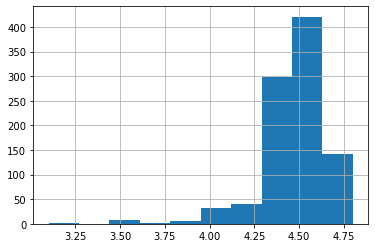

In [120]:
df.Rating.hist();

Распределение смещено вправо, книг с плохим рейтингом не так много. Переведем рейтинг в категории

In [121]:
df['Rating_cat'] = pd.cut(df.Rating, bins=[0, 4.6, 5], labels=["Not so good","Very good"])

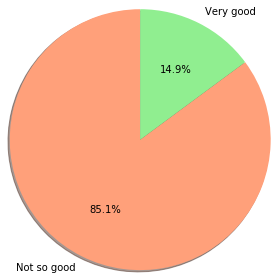

In [122]:
labels = df.Rating_cat.unique()
colors = ['lightsalmon', 'lightgreen']
plt.pie(df.Rating_cat.value_counts(), radius = 1.5, 
        labels = labels, colors = colors, autopct='%1.1f%%', shadow=True, startangle=90);

In [123]:
df.drop(['Rating'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

### Publisher

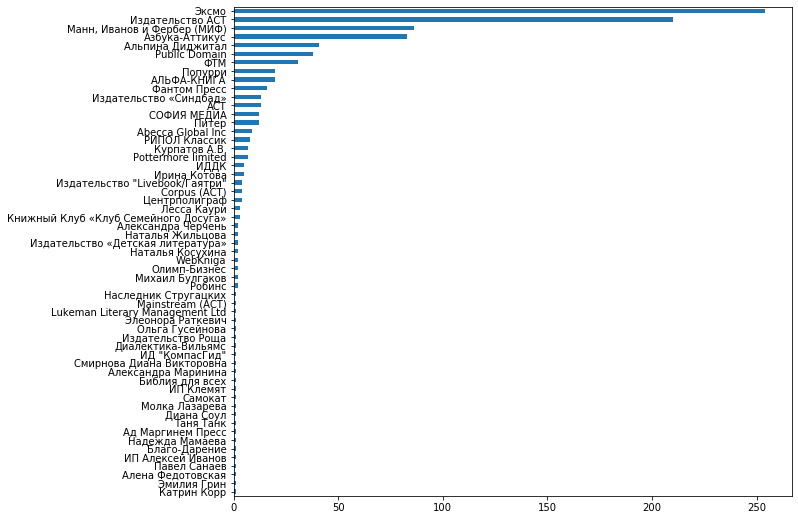

In [124]:
df.Publisher.value_counts().sort_values(ascending=True).plot.barh(figsize=(10, 9));

Посчитаем сколько книг у каждого издательства и добавим в качестве нового признака

In [125]:
published_books = df.groupby('Publisher')['Publisher'].count().to_dict()

In [126]:
df['published_books'] = df['Publisher'].map(published_books)

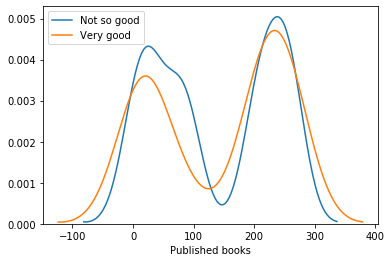

In [127]:
sns.kdeplot(df.published_books[df.Rating_cat=='Not so good'], label = 'Not so good')
#sns.kdeplot(df.published_books[df.Rating_cat=='Good'], label = 'Good')
sns.kdeplot(df.published_books[df.Rating_cat=='Very good'], label = 'Very good')
plt.xlabel('Published books');

In [128]:
df.drop(['Publisher'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

### Author

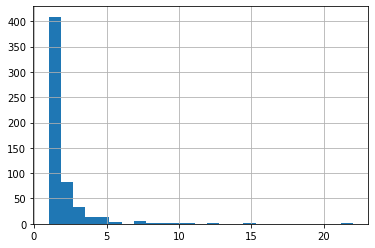

In [129]:
df.Author.value_counts().hist(bins=25);

In [130]:
books_by_author = df.groupby('Author')['Author'].count().to_dict()

In [131]:
df['books_by_author'] = df['Author'].map(books_by_author)

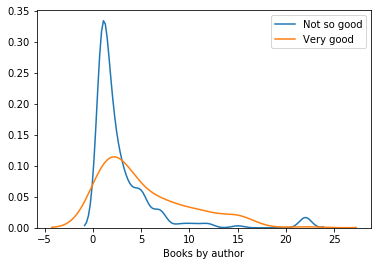

In [132]:
sns.kdeplot(df.books_by_author[df.Rating_cat=='Not so good'], label = 'Not so good')
#sns.kdeplot(df.books_by_author[df.Rating_cat=='Good'], label = 'Good')
sns.kdeplot(df.books_by_author[df.Rating_cat=='Very good'], label = 'Very good')
plt.xlabel('Books by author');

In [133]:
df.drop(['Author'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

### Age

In [134]:
df.For_age.value_counts()

16+    562
12+    230
18+    123
6+      17
0+      16
Name: For_age, dtype: int64

In [135]:
df = pd.concat([df, pd.get_dummies(df.For_age, drop_first=True)], axis=1)

In [136]:
df.drop(['For_age'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

### Genres

In [137]:
df.Genres.value_counts()

['Современная зарубежная литература']                                                             52
['Современная русская литература']                                                                27
['Саморазвитие, личностный рост', 'Зарубежная психология']                                        20
['Литература 20 века', 'Зарубежная классика']                                                     19
['Любовное фэнтези']                                                                              18
                                                                                                  ..
['Здоровье', 'Саморазвитие, личностный рост']                                                      1
['Кулинария', 'Сделай сам', 'Хобби, увлечения']                                                    1
['Энциклопедии', 'Секс, секс-руководства']                                                         1
['Литература 20 века', 'Зарубежная классика', 'Зарубежная фантастика']                     

In [138]:
df.Genres = df.Genres.apply(lambda x: x.replace('[',''))
df.Genres = df.Genres.apply(lambda x: x.replace(']',''))
df.Genres = df.Genres.apply(lambda x: x.replace("'",''))

In [139]:
mlb = MultiLabelBinarizer()
encoded = mlb.fit_transform(df['Genres'].str.split(", "))
encoded = pd.DataFrame(encoded, columns=mlb.classes_)

In [140]:
df = pd.concat([df, encoded], axis=1)

In [141]:
df.drop(['Genres'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

### Tags

In [142]:
df.Tags.value_counts()

['рассказы']                                                                                                                     8
['10 класс']                                                                                                                     4
['финансовое благополучие', 'доходы', 'частные инвестиции', 'как стать богатым']                                                 3
['любовные авантюры', 'волшебные миры', 'магия и колдовство', 'ведьмы', 'магические миры']                                       3
['любовные интриги', 'магические миры', 'невероятные приключения', 'соперничество']                                              3
                                                                                                                                ..
['шведская литература', 'жизненные ценности', 'экранизации', 'психологическая проза', 'житейские истории', 'судьба человека']    1
['деловые переговоры', 'эффективное общение', 'стратегия переговоров', 'техники вли

In [196]:
#df.Tags.apply(lambda x: ''.join(x))
df.Tags = df.Tags.apply(lambda x: x.replace('[',''))
df.Tags = df.Tags.apply(lambda x: x.replace(']',''))
df.Tags = df.Tags.apply(lambda x: x.replace("'",''))

In [197]:
mlb = MultiLabelBinarizer()
encoded = mlb.fit_transform(df['Tags'].str.split(", "))
encoded = pd.DataFrame(encoded, columns=mlb.classes_)

In [198]:
df = pd.concat([df, encoded], axis=1)

In [143]:
df.drop(['Tags'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

### Year_writing

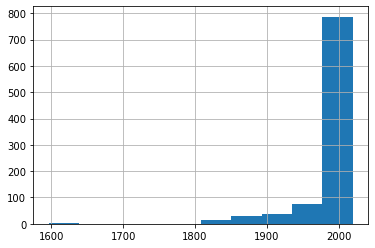

In [144]:
df.Year_writing.hist();

In [145]:
df['years_count'] = 2020 - df.Year_writing

In [146]:
df.years_count = df.years_count.apply(np.log1p)

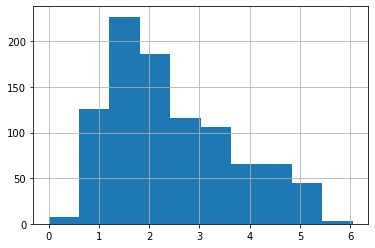

In [147]:
df.years_count.hist();

### Year_ed

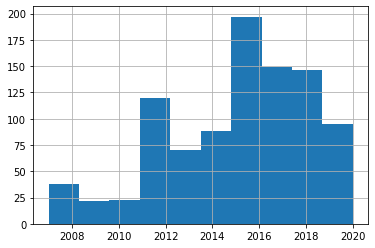

In [148]:
df.Year_ed.hist();

In [149]:
df['years_ed_count'] = 2020 - df.Year_ed

In [150]:
df.drop(columns = ['Year_writing', 'Year_ed'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

### Reader_count

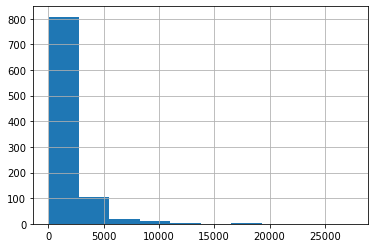

In [151]:
df.Reader_count.hist();

In [152]:
df['readers_by_year'] = df.Reader_count / df.years_ed_count.apply(lambda x: 1 if x==0 else x)

In [153]:
df[df.readers_by_year == df.readers_by_year.max()]

,Name,Reader_count,Page_count,Review_count,Citation_count,Desription,Reviews,Rating_cat,published_books,books_by_author,...,риторика,секс-руководства,сексология,театр,туризм,увлечения,фитнес,years_count,years_ed_count,readers_by_year
1,Тонкое искусство пофигизма,27546,158,65,17729,Современное общество пропагандирует культ успе...,"['Это мой старый текст, который я писала для о...",Not so good,41,2,...,0,0,0,0,0,0,0,1.609438,3,9182.0


In [154]:
df.readers_by_year = df.readers_by_year.apply(np.log)

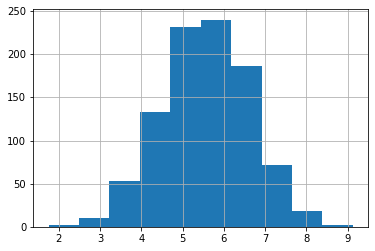

In [155]:
df.readers_by_year.hist();

In [156]:
df.drop(columns = ['Reader_count'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

### Review_count

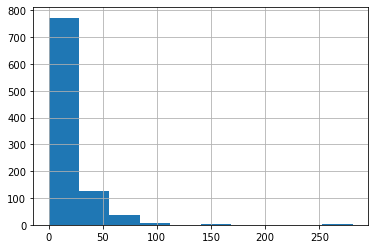

In [157]:
df.Review_count.hist();

In [158]:
df['reviews_by_year'] = df.Review_count / df.years_ed_count.apply(lambda x: 1 if x==0 else x)

In [159]:
df.reviews_by_year = df.reviews_by_year.apply(np.log1p)

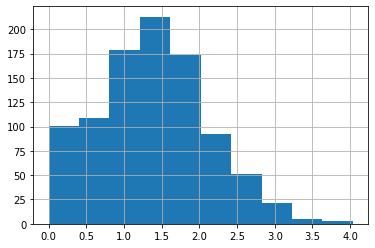

In [160]:
df.reviews_by_year.hist();

In [161]:
df.drop(columns = ['Review_count'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

### Page_count

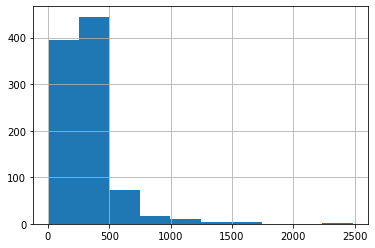

In [162]:
df.Page_count.hist();

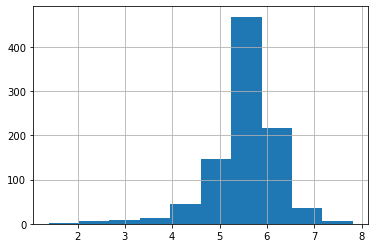

In [163]:
df.Page_count.apply(lambda x: np.log(x)).hist();

In [164]:
df.Page_count = df.Page_count.apply(np.log)

### Citation_count

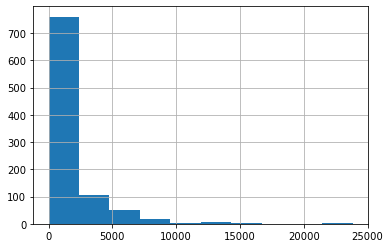

In [165]:
df.Citation_count.hist();

In [166]:
df['citations_by_year'] = df.Citation_count / df.years_ed_count.apply(lambda x: 1 if x==0 else x)

In [167]:
df.citations_by_year = df.citations_by_year.apply(np.log1p)

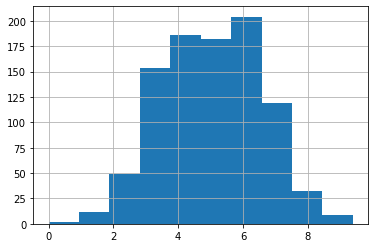

In [168]:
df.citations_by_year.hist();

In [169]:
df.drop(columns = ['Citation_count'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

Посмотрим есть ли корреляции в данных

In [170]:
to_scale = ['years_count', 'Page_count', 'years_ed_count', 'reviews_by_year', 'readers_by_year',
            'citations_by_year', 'published_books', 'books_by_author']

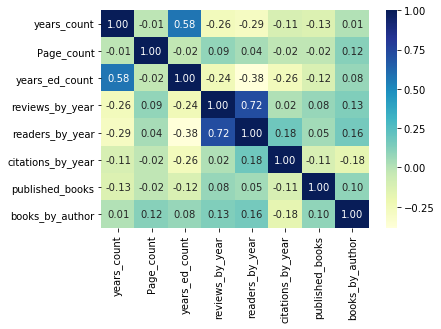

In [171]:
sns.heatmap(df[to_scale].corr(), cmap="YlGnBu", annot=True, fmt='.2f');

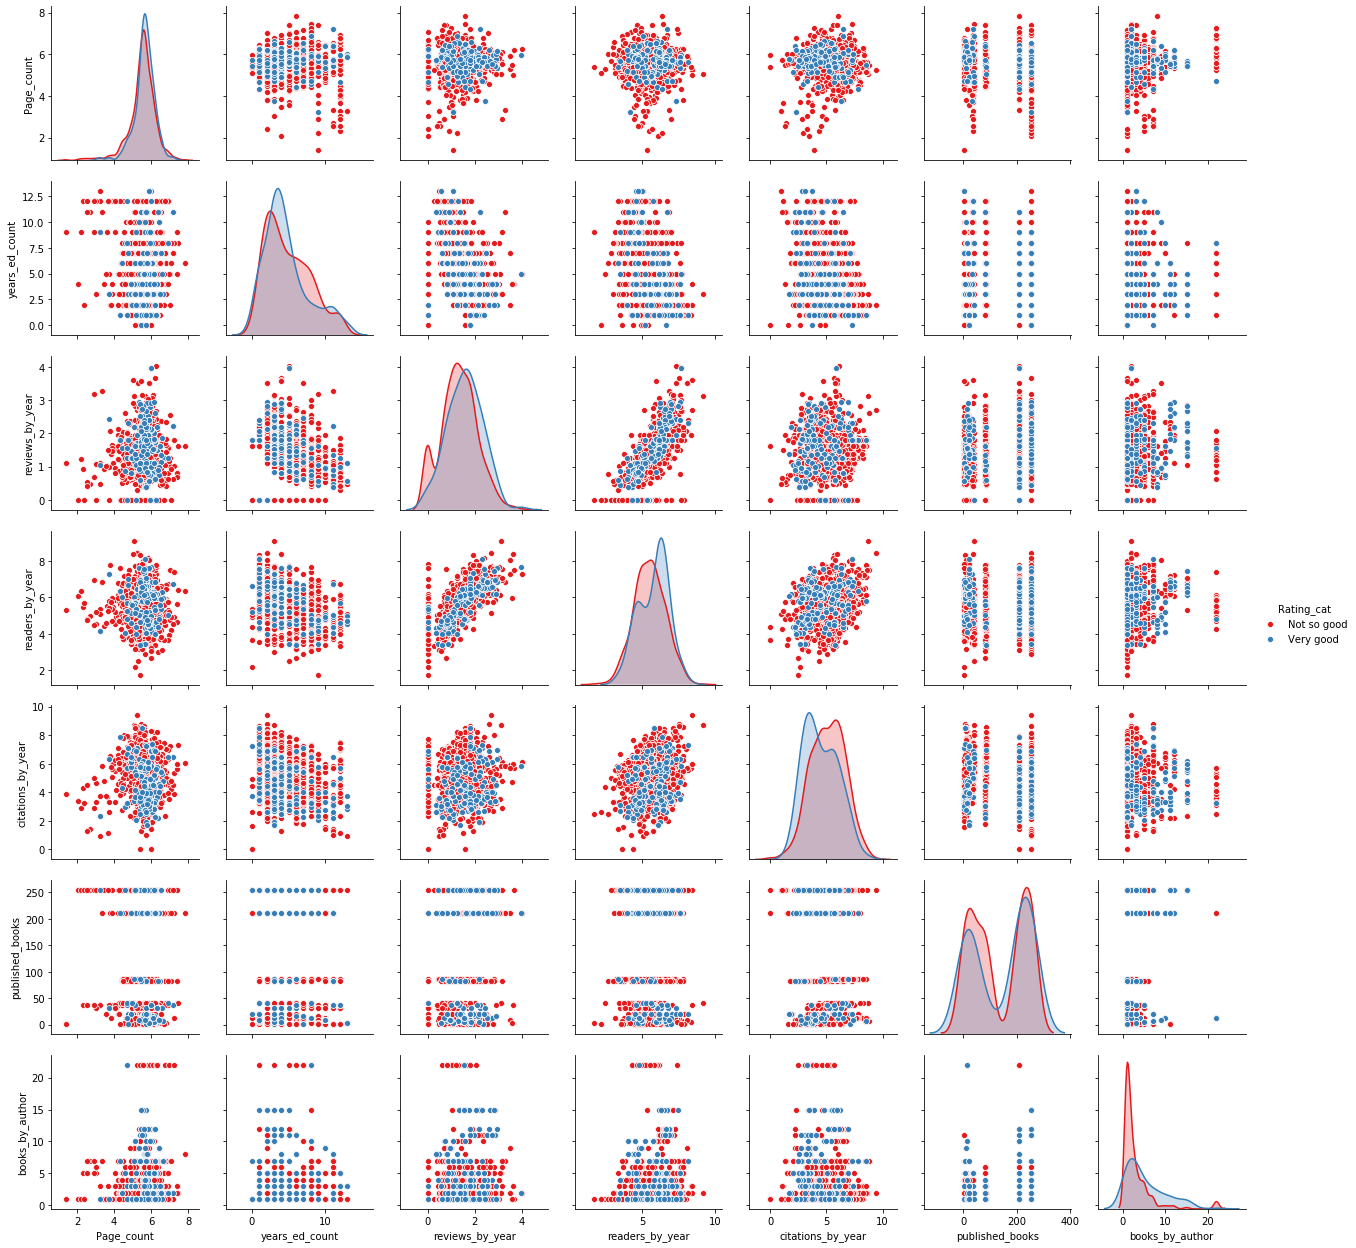

In [172]:
to_scale[0] = 'Rating_cat'
sns.pairplot(df[to_scale], hue='Rating_cat', palette='Set1');

In [173]:
df.to_csv('all_books_prepared.csv')

### Machine learning

In [285]:
df = pd.read_csv('all_books_prepared.csv', index_col=0)

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Columns: 186 entries, Name to citations_by_year
dtypes: category(1), float64(5), int32(170), int64(3), object(3), uint8(4)
memory usage: 704.6+ KB


In [175]:
df.Rating_cat = df.Rating_cat.astype('category').cat.codes

In [176]:
df.Rating_cat.value_counts()

0    807
1    141
Name: Rating_cat, dtype: int64

In [177]:
df_num = df.drop(columns = ['Name', 'Desription', 'Reviews'], axis=1)

In [178]:
to_scale = ['years_count', 'Page_count', 'years_ed_count', 'reviews_by_year', 'readers_by_year',
            'citations_by_year', 'published_books', 'books_by_author']

In [187]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [180]:
X_train, X_test, y_train, y_test = train_test_split(
    df_num.drop(['Rating_cat'], axis=1), 
    df_num['Rating_cat'], 
    test_size=0.25, 
    random_state=42,
    stratify=df_num['Rating_cat']
)

In [181]:
X_train.shape, X_test.shape

((711, 182), (237, 182))

In [182]:
X_train

,Page_count,published_books,books_by_author,12+,16+,18+,6+,Cтихи и поэзия,PR,The arts,...,сексология,театр,туризм,увлечения,фитнес,years_count,years_ed_count,readers_by_year,reviews_by_year,citations_by_year
535,5.863631,2,2,1,0,0,0,0,0,0,...,0,0,0,0,0,2.484907,6,5.327876,1.386294,3.857215
161,5.659482,210,5,0,0,1,0,0,0,0,...,0,0,0,0,0,1.386294,3,7.067888,3.135494,5.857933
377,5.356586,254,1,0,1,0,0,0,0,0,...,1,0,0,0,0,3.610918,2,5.484797,1.252763,6.415097
484,6.257668,83,6,0,1,0,0,0,0,0,...,0,0,0,0,0,0.693147,1,7.808729,2.197225,5.411646
211,6.192362,254,1,0,1,0,0,0,0,0,...,0,0,0,0,0,4.927254,4,7.486473,3.663562,5.702949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,5.579730,210,4,0,1,0,0,0,0,0,...,0,0,0,0,0,1.098612,2,6.767918,2.397895,3.663562
811,5.817111,31,3,1,0,0,0,0,0,0,...,0,0,0,0,0,4.553877,9,3.766355,0.693147,3.652100
129,5.318120,9,9,0,1,0,0,0,0,0,...,0,0,0,0,0,3.135494,10,5.426711,0.916291,3.292126
618,5.645447,83,4,0,1,0,0,0,0,0,...,0,0,0,0,0,2.890372,4,5.888185,1.558145,2.656757


In [183]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [190]:
def print_quality_report(prediction, actual):
    Accuracy = accuracy_score(prediction, actual)
    Precision = precision_score(prediction, actual, average='weighted')
    Recall = recall_score(prediction, actual, average='weighted')
    F1 = f1_score(prediction, actual, average='weighted')
    try:
        roc_auc = roc_auc_score(prediction, actual)
    except:
        roc_auc = None
        
        
    quality_list = [Accuracy, Precision, Recall, F1, roc_auc]
    
    return quality_list

**Baseline** - все рейтинги класса 0

In [188]:
y_pred_naive = np.zeros(len(y_test))

In [191]:
quality_list_naive = print_quality_report(y_pred_naive, y_test)

df_quality = pd.DataFrame(
    [quality_list_naive],
    columns=["Accuracy", "Precision", "Recall"," F1 score", "ROC AUC"],
    index=["Baseline"])

df_quality

,Accuracy,Precision,Recall,F1 score,ROC AUC
Baseline,0.852321,1.0,0.852321,0.920273,None


**Logistic Regression**

In [192]:
def get_reg_coefs(X_train, y_train, feature_columns, penalty="l1"):
    possible_Cs = np.arange(0.001,0.1,0.001)
    coefs_values = []

    for c in possible_Cs:
        model_LogR = LogisticRegression(C=c, penalty=penalty)
        model_LogR.fit(X_train_scaled, y_train)
        coefs_values.append(model_LogR.coef_[0])
    
    return pd.DataFrame(coefs_values, columns=feature_columns).sort_index(ascending=False).reset_index(drop=True)


In [193]:
coefs_df_l1 = get_reg_coefs(X_train_scaled, y_train, X_train.columns, penalty="l1")

In [194]:
def get_important_features(coefs_df_l1, n_feats_limit):
    n_imp_feats = (coefs_df_l1!=0).sum(axis=1)
    index_imp_feats = n_imp_feats[n_imp_feats<=n_feats_limit].index[0]
    row_coef = coefs_df_l1.loc[index_imp_feats, :]
    return row_coef[row_coef!=0].index.tolist()

In [195]:
reg_important_20_features = get_important_features(coefs_df_l1, n_feats_limit=20)
reg_important_20_features

['books_by_author',
 '6+',
 'Боевое фэнтези',
 'Героическое фэнтези',
 'Детективное фэнтези',
 'Исторические детективы',
 'Исторические любовные романы',
 'Киберпанк',
 'Классические детективы',
 'Книги о войне',
 'Книги про волшебников',
 'Любовное фэнтези',
 'Русское фэнтези',
 'Современная зарубежная литература',
 'Спорт',
 'Юмористическое фэнтези',
 'фитнес']

In [196]:
reg_important_30_features = get_important_features(coefs_df_l1, n_feats_limit=30)
reg_important_30_features

['books_by_author',
 '6+',
 'Боевое фэнтези',
 'Героическое фэнтези',
 'Городское фэнтези',
 'Детективное фэнтези',
 'Детские приключения',
 'Искусствоведение',
 'Исторические детективы',
 'Исторические любовные романы',
 'История искусств',
 'Киберпанк',
 'Классические детективы',
 'Книги для подростков',
 'Книги о войне',
 'Книги про вампиров',
 'Книги про волшебников',
 'Личные финансы',
 'Любовное фэнтези',
 'Мистика',
 'Русское фэнтези',
 'Сказки',
 'Современная зарубежная литература',
 'Социальная фантастика',
 'Спорт',
 'Стартапы и создание бизнеса',
 'Ужасы',
 'Экономика',
 'Юмористическое фэнтези',
 'фитнес']

In [197]:
model_LogR_20 = LogisticRegression()
model_LogR_20.fit(X_train[reg_important_20_features], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [200]:
y_pred_20 = model_LogR_20.predict(X_test[reg_important_20_features])
df_quality.loc["Logistic Regression 20", :] = print_quality_report(y_pred_20, y_test)
df_quality.round(3)

,Accuracy,Precision,Recall,F1 score,ROC AUC
Baseline,0.852,1.000,0.852,0.920,None
Logistic Regression 20,0.848,0.943,0.848,0.888,0.65424


In [203]:
model_LogR_30 = LogisticRegression()
model_LogR_30.fit(X_train[reg_important_30_features], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [204]:
y_pred_30 = model_LogR_30.predict(X_test[reg_important_30_features])
df_quality.loc["Logistic Regression 30", :] = print_quality_report(y_pred_30, y_test)
df_quality.round(3)

,Accuracy,Precision,Recall,F1 score,ROC AUC
Baseline,0.852,1.000,0.852,0.920,None
Logistic Regression 20,0.848,0.943,0.848,0.888,0.65424
Logistic Regression 30,0.852,0.920,0.852,0.880,0.68722


**RandomForest**

In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [206]:
clf_RF = RandomForestClassifier(random_state=0)

In [207]:
parameters = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6,7,8,9,10],
    'min_samples_split': [2,4,6,8],
    'criterion': ['gini', 'entropy']
}

In [208]:
grid_RF = GridSearchCV(estimator=clf_RF, param_grid=parameters, cv= 5)
grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'c

In [209]:
y_pred_rf = grid_RF.predict(X_test)
df_quality.loc["Random Forest", :] = print_quality_report(y_pred_rf, y_test)
df_quality.round(3)

,Accuracy,Precision,Recall,F1 score,ROC AUC
Baseline,0.852,1.000,0.852,0.920,None
Logistic Regression 20,0.848,0.943,0.848,0.888,0.65424
Logistic Regression 30,0.852,0.920,0.852,0.880,0.68722
Random Forest,0.865,0.976,0.865,0.911,0.83319


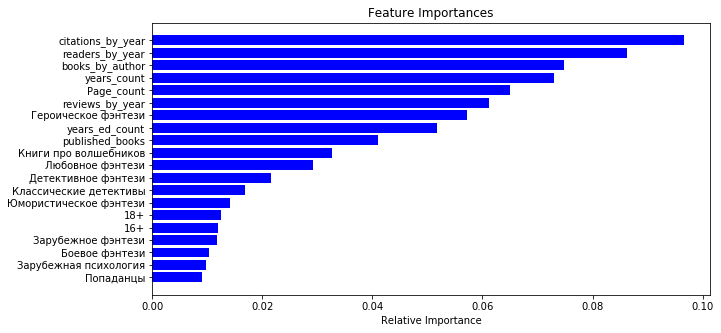

In [210]:
grid_RF.best_estimator_.feature_importances_
features = X_train.columns
importances = grid_RF.best_estimator_.feature_importances_
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show();

**SGD Classifier**

In [211]:
from sklearn.linear_model import SGDClassifier

In [212]:
clf = SGDClassifier(random_state=42, class_weight="balanced", n_jobs=-1)

In [213]:
param_grid = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1"],
}

In [214]:
grid_search = GridSearchCV(clf, param_grid=param_grid)
grid_search.fit(X_train_scaled, y_train)

c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight='balanced',
                                     early_stopping=False, epsilon=0.1,
                                     eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=-1,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log', 'squared_hinge',
                          

In [215]:
y_pred_gs = grid_search.predict(X_test_scaled)
df_quality.loc["SGD Classifier", :] = print_quality_report(y_pred_gs, y_test)
df_quality.round(3)

,Accuracy,Precision,Recall,F1 score,ROC AUC
Baseline,0.852,1.000,0.852,0.920,None
Logistic Regression 20,0.848,0.943,0.848,0.888,0.65424
Logistic Regression 30,0.852,0.920,0.852,0.880,0.68722
Random Forest,0.865,0.976,0.865,0.911,0.83319
SGD Classifier,0.814,0.843,0.814,0.828,0.596321


**SVM**

In [216]:
from sklearn import svm
from sklearn.model_selection import StratifiedKFold

In [219]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
classes = ['balanced']
kernels = ['poly', 'rbf', 'sigmoid']

param_svc_grid = {
    'C': Cs,
    'gamma' : gammas,
    'class_weight' : classes,
    'kernel': kernels
}

svc = svm.SVC()

svc_search = RandomizedSearchCV(svc, param_svc_grid, scoring='roc_auc', cv = StratifiedKFold(5), n_jobs=-1)
svc_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'class_weight': ['balanced'],
                                        'gamma': [0.001, 0.01, 0.1, 1],
                                        'kernel': ['poly', 'rbf', 'sigmoid']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                 

In [220]:
y_pred_svm = svc_search.predict(X_test_scaled)
df_quality.loc["SVM ", :] = print_quality_report(y_pred_svm, y_test)
df_quality.round(3)

,Accuracy,Precision,Recall,F1 score,ROC AUC
Baseline,0.852,1.000,0.852,0.920,None
Logistic Regression 20,0.848,0.943,0.848,0.888,0.65424
Logistic Regression 30,0.852,0.920,0.852,0.880,0.68722
Random Forest,0.865,0.976,0.865,0.911,0.83319
SGD Classifier,0.814,0.843,0.814,0.828,0.596321
SVM,0.823,0.813,0.823,0.817,0.661399


### NLP

In [16]:
df = pd.read_csv('all_books_prepared.csv', index_col=0)

In [17]:
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import re

In [18]:
df['Reviews'] 

0      ['Эта книга - как свежий воздух из окна. Она н...
1      ['Это мой старый текст, который я писала для о...
2      ['Вам знакомо это чувство, когда открываешь кн...
3      ['СознаниеДля того, чтобы сдвинуться с места, ...
4      ['Есть у меня guilty pleasure – читать всяческ...
                             ...                        
943    ['...Пусть это пир во время чумы, но это все-т...
944    ['Эта книга настоящий дар для каждого человека...
945    ['Отличный и захватывающий фэнтези детектив.Эт...
946    ['И это - детская литература?! С каких это пор...
947    ['Знаете вот это мерзкое ощущение, когда и пог...
Name: Reviews, Length: 948, dtype: object

In [19]:
#df['Reviews'] = df['Reviews'].apply(lambda x: ''.join(BeautifulSoup(x).findAll(text=True)))

In [20]:
m = Mystem()

In [21]:
stop = stopwords.words('russian')

def data_stop(text):
    return ' '.join([word for word in text.split(' ') if word not in stop])

In [22]:
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [23]:
def cleanString(myString):
    return re.sub(r'[^\w\s]','',myString)

In [24]:
all_reviews = df['Reviews'].apply(lambda x: x.lower())

In [25]:
all_reviews = all_reviews.apply(lambda x: cleanString(x))

In [26]:
all_reviews = all_reviews.apply(lambda x: data_stop(x))
all_reviews

0      эта книга  свежий воздух окна написана человек...
1      это старый текст который писала обзора сразу н...
2      знакомо это чувство открываешь книгу читаешь п...
3      сознаниедля сдвинуться места необходимо  это д...
4      guilty pleasure  читать всяческие популярнопси...
                             ...                        
943    пусть это пир время чумы это всетаки красивый ...
944    эта книга настоящий дар каждого человека  прос...
945    отличный захватывающий фэнтези детективэто мир...
946    это  детская литература каких это пор пьянки д...
947    знаете это мерзкое ощущение погода хорошая ком...
Name: Reviews, Length: 948, dtype: object

In [27]:
all_reviews = all_reviews.apply(lemmatize)
all_reviews

0      этот книга  свежий воздух окно написать челове...
1      это старый текст который писать обзор сразу не...
2      знакомый этот чувство открывать книга читать п...
3      сознаниедля сдвигаться место необходимо  это д...
4      guilty pleasure  читать всяческий популярнопси...
                             ...                        
943    пусть это пир время чума это всетака красивый ...
944    этот книга настоящий дар каждый человек  прост...
945    отличный захватывать фэнтези детективэто мир к...
946    это  детский литература какой это пора пьянка ...
947    знать это мерзкий ощущение погода хороший комп...
Name: Reviews, Length: 948, dtype: object

In [29]:
from wordcloud import WordCloud

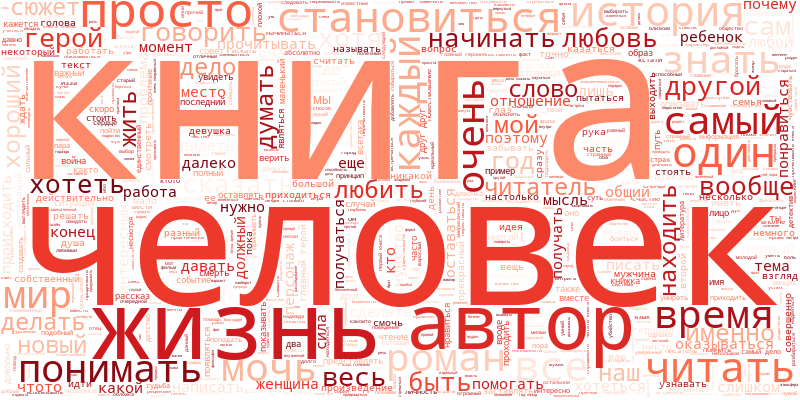

In [33]:
cloud = ''
for i in all_reviews:
    cloud += (' '+i)

bannedWord = ['это', 'который', 'такой', 'свой', 'этот', 'тот']
cloud = ' '.join(i for i in cloud.split() if i not in bannedWord)
    
wordcloud = WordCloud(background_color="white", max_words=3000, colormap='Reds', width=800, height=400)
wordcloud = wordcloud.generate(cloud)
wordcloud.to_image()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [29]:
tf_vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2))

In [30]:
X_train_vector = tf_vectorizer.fit_transform(all_reviews)
X_train_vector.shape

(948, 452884)

In [31]:
Xtr, Xval, ytr, yval  = train_test_split(X_train_vector, df.Rating_cat, test_size=0.25, random_state=42, stratify=df.Rating_cat)

In [32]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [33]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet"],
}

In [34]:
logit_sgd = SGDClassifier(random_state=42, class_weight="balanced", n_jobs=-1)

In [35]:
clf_sgd = GridSearchCV(logit_sgd, param_grid=params)

In [36]:
clf_sgd.fit(Xtr, ytr)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight='balanced',
                                     early_stopping=False, epsilon=0.1,
                                     eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=-1,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log', 'squared_hinge',
                          

In [37]:
print(accuracy_score(clf_sgd.predict(Xtr), ytr))
print(accuracy_score(clf_sgd.predict(Xval), yval))

print(classification_report(clf_sgd.predict(Xval), yval))

0.9929676511954993
0.8649789029535865
              precision    recall  f1-score   support

 Not so good       0.97      0.88      0.92       222
   Very good       0.26      0.60      0.36        15

    accuracy                           0.86       237
   macro avg       0.61      0.74      0.64       237
weighted avg       0.93      0.86      0.89       237



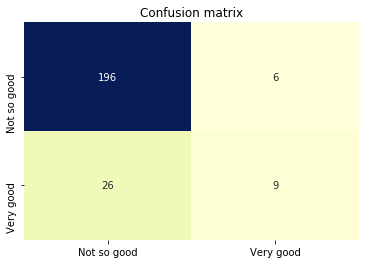

In [38]:
array = confusion_matrix(yval, clf_sgd.predict(Xval))
cm = pd.DataFrame(array, index = df.Rating_cat.unique(),
                      columns = df.Rating_cat.unique())
sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu", cbar=False)
plt.title('Confusion matrix');